In [ ]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict

In [ ]:
load_dotenv(override=True)

In [ ]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of India?")

LangChain wrapper which convers function into Tools

In [ ]:
from langchain_core.tools import Tool

tool_search = Tool(
    name="search",
    func=serper.run,
    description="Usefull for when you need more information from an online search"
)

In [ ]:
tool_search.invoke("What is the capital of tamilnadu?")

In [ ]:
import sys
sys.path.append(os.path.abspath('..'))

from utilities import send_message

tool_notification = Tool(
    name="send_push_notification",
    func=send_message,
    description="Useful for when you want to send a push notification"
)

In [ ]:
tool_notification.invoke("Hi Sana & Viyan, What are you doing?")

Defining the graph

In [ ]:
tools = [tool_search, tool_notification]

In [ ]:
# Step 1: Create state
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
# Step 2: Start the graph builder with State.
graph_build = StateGraph(State)

In [ ]:
llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# Step3: Create Nodes

def chat_bot(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_build.add_node('chat_bot', chat_bot)
graph_build.add_node('tools', ToolNode(tools=tools))

In [ ]:
# Step 4: Create Edges

graph_build.add_conditional_edges('chat_bot', tools_condition, 'tools')

graph_build.add_edge('tools', 'chat_bot')
graph_build.add_edge(START,'chat_bot')

In [ ]:
# Step 5: Compile the graph

graph = graph_build.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Now the use the above defined graph

In [ ]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat).launch()

## Checkpointing - Storing the state between super step.
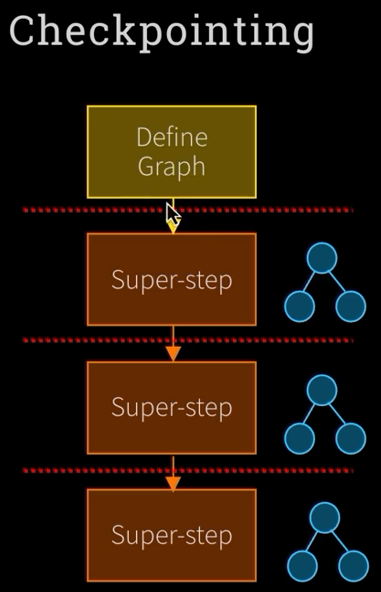
> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
#Step 1 & 2
graph_builder = StateGraph(State)

llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools)

# Step 3
def chat_bot(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node('chat_bot', chat_bot)
graph_builder.add_node('tools', ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges('chat_bot', tools_condition, 'tools')

graph_builder.add_edge('tools', 'chat_bot')
graph_builder.add_edge(START,'chat_bot')

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat).launch()

### Storing memory in sqlite
To use sqlite we need to install langgraph-checkpoint-sqlite package.

```bash
uv add langgraph-checkpoint-sqlite
```

In [ ]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = 'memory.db'
conn = sqlite3.connect(db_path, check_same_thread=False)
sqlite_memory = SqliteSaver(conn)

In [ ]:
#Step 1 & 2
graph_builder = StateGraph(State)

llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools)

# Step 3
def chat_bot(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node('chat_bot', chat_bot)
graph_builder.add_node('tools', ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges('chat_bot', tools_condition, 'tools')

graph_builder.add_edge('tools', 'chat_bot')
graph_builder.add_edge(START,'chat_bot')

graph = graph_builder.compile(checkpointer=sqlite_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat).launch()